In [2]:
# Import necessary packages
import pandas as pd
import random
from matplotlib import pyplot as plt

In [26]:
from concurrent.futures import ProcessPoolExecutor
import os

In [4]:
# Helper function to check if two blocks share an edge
def shares_edge(block_a, block_b):
    # Check for shared vertical edges
    if (block_a['x2'] == block_b['x1'] and max(block_a['y1'], block_b['y1']) < min(block_a['y3'], block_b['y3'])) or \
       (block_a['x1'] == block_b['x2'] and max(block_a['y1'], block_b['y1']) < min(block_a['y3'], block_b['y3'])):
        return True
    # Check for shared horizontal edges
    if (block_a['y3'] == block_b['y1'] and max(block_a['x1'], block_b['x1']) < min(block_a['x2'], block_b['x2'])) or \
       (block_a['y1'] == block_b['y3'] and max(block_a['x1'], block_b['x1']) < min(block_a['x2'], block_b['x2'])):
        return True
    return False

In [27]:
class PlanarStoLattice:
    def __init__(self, time=1, load_lattice=False, lattice_path="lattice_with_neighbors.csv"):
        self.blocks = [{
            'x1': 0, 'y1': 0,
            'x2': 1, 'y2': 0,
            'x3': 1, 'y3': 1,
            'x4': 0, 'y4': 1,
            'xlen': 1, 'ylen': 1,
            'neighbors': None}]
        self.time = time
        self.num_of_blocks = 3*self.time + 1
        self.lattice = None  # This will store the dataframe with all information about the lattice
        self.percolation = None  # This will store percolation data

        if load_lattice:
            self.lattice = pd.read_csv(lattice_path)
            self.num_of_blocks = len(self.lattice)
            self.time = (self.num_of_blocks - 1)/3
            self.update_coords_and_area()

    def update_coords_and_area(self):
        # Extract the coordinates for all blocks once, before the loop
        self.x1_coords = self.blocks['x1'].values
        self.x2_coords = self.blocks['x2'].values
        self.y1_coords = self.blocks['y1'].values
        self.y3_coords = self.blocks['y3'].values
        self.areas = self.blocks['area'].values
        # Convert blocks to a more efficient structure
        self.block_neighbors = self.blocks['neighbors'].apply(set).tolist()

    def generate(self, path="lattice_with_neighbors.csv"):
        linewidth = 0.4
        # Draw initial square
        plt.hlines([0, 1], 0, 1, linewidth=linewidth)
        plt.vlines([0, 1], 0, 1, linewidth=linewidth)

        for _ in range(self.time):
            # Choose a random block
            selected_idx = random.randint(0, len(self.blocks) - 1)
            selected_block = self.blocks[selected_idx]

            # Calculate random lengths
            num_x = random.random() * selected_block['xlen']
            num_y = random.random() * selected_block['ylen']

            # Calculate new block coordinates
            x1, y1 = selected_block['x1'], selected_block['y1']
            x2, y2 = x1 + num_x, y1 + num_y
            x3, y3 = selected_block['x2'], selected_block['y4']

            # Draw dividing lines
            plt.hlines(y2, x1, x3, linewidth=linewidth)
            plt.vlines(x2, y1, y3, linewidth=linewidth)

            # Length of blocks
            l = len(self.blocks)

            # Create new blocks
            block_1 = {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y1, 'x3': x2, 'y3': y2, 'x4': x1, 'y4': y2, 'xlen': num_x, 'ylen': num_y, 'neighbors':[l, l+2]}
            block_2 = {'x1': x2, 'y1': y1, 'x2': x3, 'y2': y1, 'x3': x3, 'y3': y2, 'x4': x2, 'y4': y2, 'xlen': x3-x2, 'ylen': num_y, 'neighbors':[selected_idx, l+1]}
            block_3 = {'x1': x2, 'y1': y2, 'x2': x3, 'y2': y2, 'x3': x3, 'y3': y3, 'x4': x2, 'y4': y3, 'xlen': x3-x2, 'ylen': y3-y2, 'neighbors':[l, l+2]}
            block_4 = {'x1': x1, 'y1': y2, 'x2': x2, 'y2': y2, 'x3': x2, 'y3': y3, 'x4': x1, 'y4': y3, 'xlen': num_x, 'ylen': y3-y2, 'neighbors':[selected_idx, l+1]}

            # Save parents neighbors
            neighbors = self.blocks[selected_idx]['neighbors']

            # Replace the selected block with the new blocks
            self.blocks[selected_idx] = block_1
            self.blocks.extend([block_2, block_3, block_4])

            # Update neighbors
            if neighbors is not None:
                for j in neighbors:
                    self.blocks[j]['neighbors'].remove(selected_idx)  # Delete selected block index from the previous neighbors
                for i in [selected_idx, l, l+1, l+2]:
                    for j in neighbors:
                        if shares_edge(self.blocks[i], self.blocks[j]):
                            self.blocks[i]['neighbors'].append(j)
                            self.blocks[j]['neighbors'].append(i)

        # Convert final list of blocks to a DataFrame
        self.blocks = pd.DataFrame(self.blocks)

        # Count number of neighbors for each block
        self.blocks["number_of_neighbors"] = [len(i) for i in self.blocks["neighbors"]]

        # Area of each block
        self.blocks["area"] = self.blocks["xlen"] * self.blocks["ylen"]

        # Update object coord_and_area
        self.update_coords_and_area()

        # Save the generated lattice
        self.save_lattice(path=path)

        # Save the figure
        plt.savefig("lattice_image.png", dpi=1000)

    def save_lattice(self, path="lattice_with_neighbors.csv"):
        self.blocks.to_csv(path, index=False)

    def save_percolation(self, path="percolation_data.csv"):
        self.percolation.to_csv(path, index=False)

    def percolate(self, path="percolation_data.csv", area_dist = True, span_dist = True):
        # area_dist: Tracking area distribution is a computationally heavy task. Set it true only when necessary
        # Generate random sequence of percolation
        list_of_idx = list(range(self.num_of_blocks))
        random.shuffle(list_of_idx)
        # print(list_of_idx)
    
        # Variables to store clusters data and percolation data
        clusters = {}  # {({bloccks idxes forming the cluster}, {neigbors idxes}, [area of the cluster])}
        percolation_data = []
    
        does_span = False  # Variable to check if we have a spanning cluster

        #A variable to store the total cluster area
        clusters_area = 0
    
        # Start percolation
        for count, idx in enumerate(list_of_idx):
            # Set of cluster indexes which neighbors list contain the new block
            expanding_clusters_idx = set()
    
            # Check if the new block is a new cluster or expands existing cluster(s)
            for cluster_idx, (cluster_blocks, cluster_neighbors, areas) in clusters.items():
                if idx in cluster_neighbors:
                    expanding_clusters_idx.add(cluster_idx)
    
            # If the new block is a new cluster, create a new entry
            if not expanding_clusters_idx:
                clusters[count] = ({idx}, self.block_neighbors[idx], self.areas[idx] if area_dist else 0)
            else:
                # Merge expanding clusters
                new_cluster = set()
                new_neighbor_list = set()
                new_areas = 0
                for cluster_idx in expanding_clusters_idx:
                    blocks, neighbors, areas = clusters.pop(cluster_idx)
                    new_cluster.update(blocks)
                    new_neighbor_list.update(neighbors)
                    # Calculate area if area_dist is true
                    if area_dist:
                        new_areas = new_areas + areas
    
                # Include the new block
                new_cluster.add(idx)
                new_neighbor_list.update(self.block_neighbors[idx])
                new_neighbor_list.difference_update(new_cluster)
                if area_dist:
                    new_areas = new_areas + self.areas[idx]
    
                # Update the clusters
                clusters[count] = (new_cluster, new_neighbor_list, new_areas)
    
            # Check if the new cluster spans the lattice
            if not does_span:
                does_span = self.check_spanning(clusters[count][0])
    
            # Calculate total area of all clusters
            clusters_area += self.areas[idx]

            if span_dist and does_span:
                # (Spanned cluster area, total occupied area, count, num of clusters while spans)
                return (areas, clusters_area, count + 1, len(clusters))

            if not span_dist:
                # Store necessary data in dictionary
                percolation_data.append({
                    "n": count + 1,
                    "number_of_clusters": len(clusters),
                    "does_span": does_span,
                    "total_cluster_area": clusters_area,
                    "occupation_prob": (count + 1) / self.num_of_blocks
                })
        if not span_dist:
            self.percolation = pd.DataFrame(percolation_data)
            self.save_percolation(path=path)

    def check_spanning(self, cluster_blocks):        
        # Initialize variables to track the minimum and maximum coordinates
        min_x, max_x = 1, 0
        min_y, max_y = 1, 0
        
        # Iterate over each block index in the cluster
        for block_idx in cluster_blocks:
            # Update the minimum and maximum x and y coordinates
            min_x = min(min_x, self.x1_coords[block_idx], self.x2_coords[block_idx])
            max_x = max(max_x, self.x1_coords[block_idx], self.x2_coords[block_idx])
            min_y = min(min_y, self.y1_coords[block_idx], self.y3_coords[block_idx])
            max_y = max(max_y, self.y1_coords[block_idx], self.y3_coords[block_idx])
        
        # Check if the cluster spans horizontally from x=0 to x=1
        horizontal_spanning = min_x == 0 and max_x == 1
        # Check if the cluster spans vertically from y=0 to y=1
        vertical_spanning = min_y == 0 and max_y == 1
    
        return horizontal_spanning or vertical_spanning

    # def spanning_prob_dist(self, iter = 10):
    #     data = []
    #     for m in range(iter):
    #         spanning_area, cluster_area, spanning_n, num_clusters = self.percolate()
    #         data.append({"spanning cluster area": spanning_area,
    #                     "total occupied area": cluster_area,
    #                     "total num of clusters": num_clusters,
    #                     "spanning_n": spanning_n,
    #                     "spanning prob": spanning_n/self.num_of_blocks})
    #     dist_data = pd.DataFrame(data)
    #     dist_data.to_csv("spanning probability dist.csv", index=False)
    #     return pd.DataFrame(data)
    
    
    def _percolate_wrapper(self):
        spanning_area, cluster_area, spanning_n, num_clusters = self.percolate()
        return {
            "spanning cluster area": spanning_area,
            "total occupied area": cluster_area,
            "total num of clusters": num_clusters,
            "spanning_n": spanning_n,
            "spanning prob": spanning_n / self.num_of_blocks
        }

#     def spanning_prob_dist(self, iter=10):
#         with ProcessPoolExecutor() as executor:
#             futures = [executor.submit(self._percolate_wrapper) for _ in range(iter)]
#             data = [future.result() for future in futures]

#         dist_data = pd.DataFrame(data)
#         dist_data.to_csv("spanning probability dist.csv", index=False)
#         return dist_data

#     def spanning_prob_dist(self, iter=100):
#         batch_size = 100
#         all_data = []

#         with ProcessPoolExecutor() as executor:
#             for i in range(0, iter, batch_size):
#                 # Determine the size of the current batch
#                 current_batch_size = min(batch_size, iter - i)

#                 # Submit a batch of jobs to the executor
#                 futures = [executor.submit(self._percolate_wrapper) for _ in range(current_batch_size)]

#                 # Collect the results for the current batch
#                 data = [future.result() for future in futures]
#                 all_data.extend(data)

#                 # Convert the current batch of results to a DataFrame
#                 batch_data = pd.DataFrame(data)

#                 # Save the current batch to CSV
#                 # If it's the first batch, write header, otherwise append without header
#                 batch_data.to_csv("spanning probability dist.csv", mode='a', index=False, header=not i)

#         # Combine all batches into a single DataFrame
#         dist_data = pd.DataFrame(all_data)
#         return dist_data

    def spanning_prob_dist(self, iter=10):
        batch_size = 100
        all_data = []
        # Filename includes the number of iterations (self.time)
        filename = f"spanning probability dist t_{self.time}.csv"
        # Check if the file already exists
        file_exists = os.path.isfile(filename)
        
        with ProcessPoolExecutor() as executor:
            for i in range(0, iter, batch_size):
                # Determine the size of the current batch
                current_batch_size = min(batch_size, iter - i)
                
                # Submit a batch of jobs to the executor
                futures = [executor.submit(self._percolate_wrapper) for _ in range(current_batch_size)]
                
                # Collect the results for the current batch
                data = [future.result() for future in futures]
                all_data.extend(data)

                # Convert the current batch of results to a DataFrame
                batch_data = pd.DataFrame(data)
                
                # Save the current batch to CSV
                # If it's the first batch and the file does not exist, write header
                # Otherwise, append without header
                batch_data.to_csv(filename, mode='a', index=False, header=not (i or file_exists))
                file_exists = True  # Set to True as file will exist after the first write
        
        # Combine all batches into a single DataFrame
        dist_data = pd.DataFrame(all_data)
        return dist_data


22.96267056465149


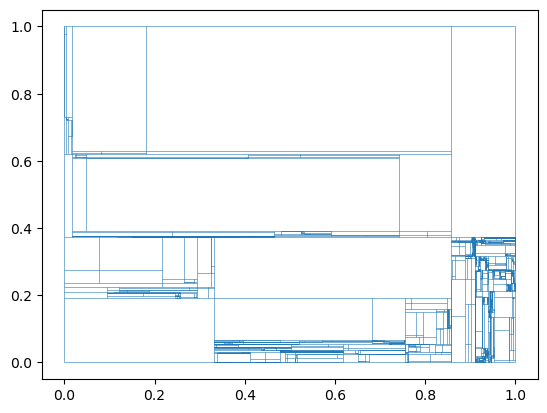

In [31]:
import time
lattice2d = PlanarStoLattice(10000)
start = time.time()
lattice2d.generate()
end = time.time()
print(end - start)

In [32]:
start = time.time()
lattice2d.percolate()
end = time.time()
print(end - start)

9.412530183792114


In [35]:
start = time.time()
lattice2d.spanning_prob_dist(800)
end = time.time()
print(end - start)

2772.3288321495056


         7074933 function calls in 15.531 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   11.687   11.687   15.528   15.528 1572727246.py:105(percolate)
    22422    2.256    0.000    3.580    0.000 1572727246.py:181(check_spanning)
  3374106    0.676    0.000    0.676    0.000 {built-in method builtins.min}
  3374106    0.648    0.000    0.648    0.000 {built-in method builtins.max}
    55615    0.153    0.000    0.153    0.000 {method 'update' of 'set' objects}
    14879    0.047    0.000    0.047    0.000 {method 'difference_update' of 'set' objects}
    45000    0.020    0.000    0.028    0.000 random.py:239(_randbelow_with_getrandbits)
        1    0.017    0.017    0.045    0.045 random.py:380(shuffle)
    35247    0.006    0.000    0.006    0.000 {method 'add' of 'set' objects}
    20368    0.006    0.000    0.006    0.000 {method 'pop' of 'dict' objects}
    65761    0.005    0.000    0.005    0.000 {met

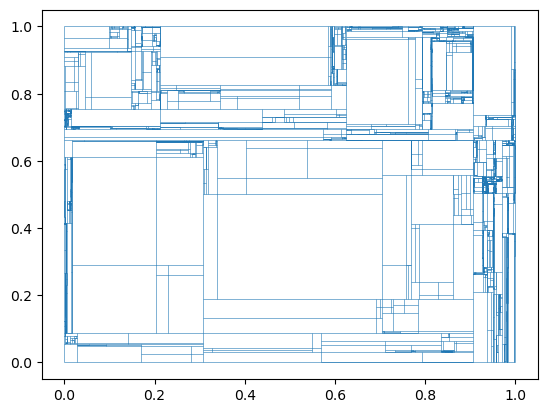

In [11]:
# Performance check
import cProfile

# Assuming you have an instance of PlanarStoLattice called lattice
lattice = PlanarStoLattice(time=15000)
lattice.generate()

# Now profile the percolate method
cProfile.run('lattice.percolate(area_dist = True)', sort='tottime')

In [17]:
test = (1,{1,2},[2])

In [18]:
test[2][0] = test[2][0] + 2

In [19]:
test

(1, {1, 2}, [4])

In [12]:
np.array([2])

array([2])